# Create a stereo depth map
Use the cv2.stereoBM class to generate a depth map

Images need to be aligned for this to work well, using homography to get them orientated the same direction

This results in a pretty poor depth map. Believe part of the issue is the parameters are not tuned well. There is also likely issues with how the images are aligned
See the 'stereoParams.py' program to see how changing the parameters changes the depth map

In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

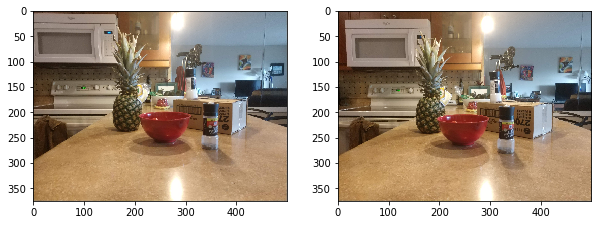

In [2]:
scale = .125

image_left = cv2.imread("images/pineapple_left.jpg")
image_right = cv2.imread("images/pineapple_right.jpg")
image_left = cv2.resize(image_left,(0,0),fx=scale,fy=scale)
image_right = cv2.resize(image_right,(0,0),fx=scale,fy=scale)
plt.rcParams['figure.figsize'] = [10,10]
plt.subplot(1,2,1)
plt.imshow(image_left[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(image_right[:,:,::-1])
plt.show()

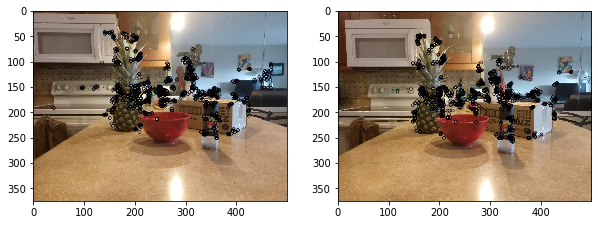

In [3]:
left_gray = cv2.cvtColor(image_left,cv2.COLOR_BGR2GRAY)
right_gray = cv2.cvtColor(image_right,cv2.COLOR_BGR2GRAY)
orb = cv2.ORB_create(nfeatures=1000)

kps1, descs1 = orb.detectAndCompute(left_gray,None)
kps2, descs2 = orb.detectAndCompute(right_gray,None)

left_with_kps = image_left.copy()
right_with_kps = image_right.copy()

plt.subplot(1,2,1)
plt.imshow(cv2.drawKeypoints(left_with_kps,kps1,left_with_kps,cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)[:,:,::-1])

plt.subplot(1,2,2)
plt.imshow(cv2.drawKeypoints(right_with_kps,kps2,right_with_kps,cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)[:,:,::-1])

plt.show()

Found 121 matches from 1000


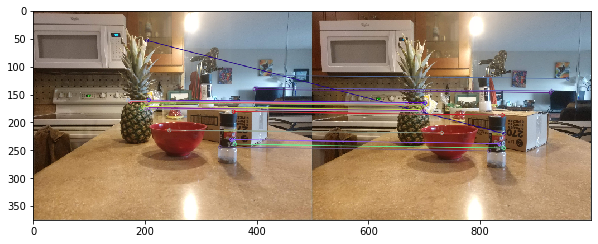

In [4]:
MIN_MATCH_COUNT = 10
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                  table_number =12, # 12
                  key_size = 10,     # 20
                  multi_probe_level = 2) #2
search_params = {"checks":100}

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(descs1, descs2, k=2)
#matches = [m[0] for m in matches]


# keep good matches
good = [m for m,n in matches if m.distance<0.7*n.distance]
print(f"Found {len(good)} matches from {len(matches)}")

    
img3 = cv2.drawMatches(image_left,kps1, image_right,kps2, good[:20],None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3[:,:,::-1])
plt.show()

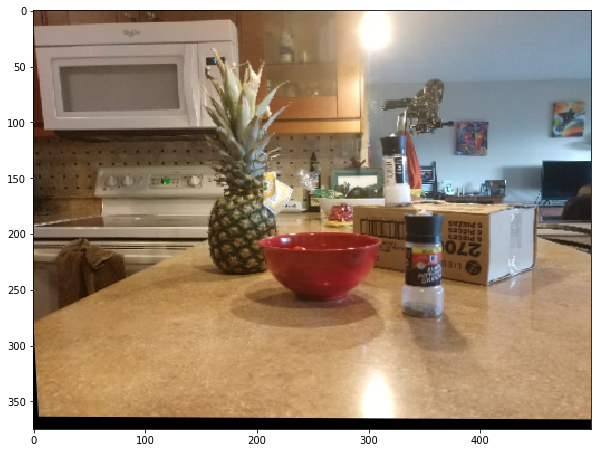

In [5]:
matches= good
if len(matches) > MIN_MATCH_COUNT:
    src_points = np.float32([ kps2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    dst_points = np.float32([ kps1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    
    
    M, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    
    h,w,d = image_right.shape
    pts = np.float32([ [0,0], [0,h-1], [w-1,h-1], [w-1,0]]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    imgOut = image_left.copy()
    imgOut = cv2.polylines(imgOut, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    #imgOut = cv2.fillPoly(imgOut, [dst.astype(np.int32)],(255,255,0),8)
    plt.imshow(imgOut)
else:
    print("Not enough matches found")

image_right_homography = cv2.warpPerspective(image_right,M,(image_left.shape[1],image_left.shape[0]))
plt.imshow(image_right_homography[:,:,::-1])

# Have images aligned, Now do stereo match

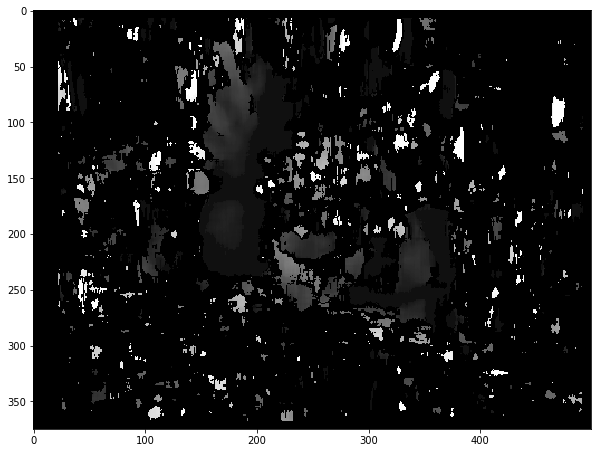

In [6]:
#stereo = cv2.StereoSGBM_create()
stereo = cv2.StereoBM_create(numDisparities=16,
                             blockSize=15,)
disparity = stereo.compute(cv2.cvtColor(image_left,cv2.COLOR_BGR2GRAY),
                           cv2.cvtColor(image_right_homography,cv2.COLOR_BGR2GRAY))
plt.imshow(disparity,cmap="gray")
plt.show()

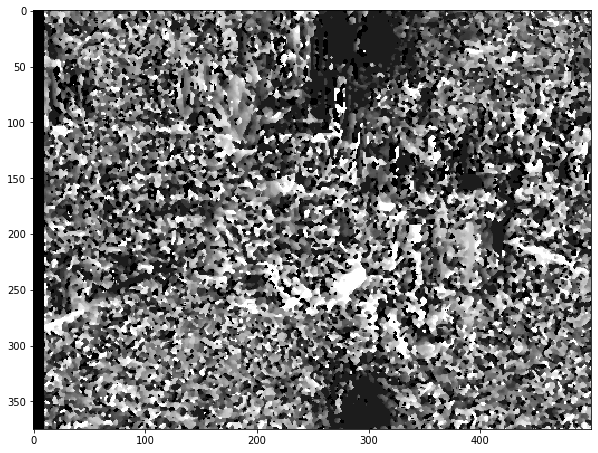

In [7]:
stereo = cv2.StereoSGBM_create(1,9)
#stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(cv2.cvtColor(image_left,cv2.COLOR_BGR2GRAY),
                           cv2.cvtColor(image_right,cv2.COLOR_BGR2GRAY))
plt.imshow(disparity,cmap="gray")
plt.show()

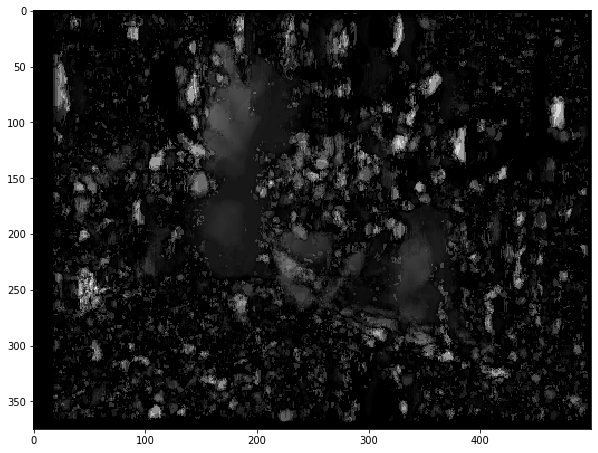

In [8]:
disparity = np.zeros((image_left.shape[0],image_left.shape[1]),np.float32)
#stereo = cv2.StereoSGBM_create()
for blockSize in [7,11,15,21,31,51,71]:
    stereo = cv2.StereoBM_create(numDisparities=16,
                                 blockSize=blockSize)
    disparity += stereo.compute(cv2.cvtColor(image_left,cv2.COLOR_BGR2GRAY),
                               cv2.cvtColor(image_right_homography,cv2.COLOR_BGR2GRAY)).astype(np.float32)
plt.imshow(disparity/disparity.max(),cmap="gray")
plt.show()